In [1]:
%matplotlib inline

In [14]:
import torch
import torch.utils.data as data
import torch.nn.functional as F
from torchvision import transforms
from functools import partial


from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

import random
import os
import unicodedata
import string
import json

In [3]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('L')

In [4]:
# This code is taken from https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/
# which is from imutils and that uses the MIT License. The author of this code is Adrian Rosebrock.
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

In [5]:
def tensor_rotate_bound(angle, tensor):
    return torch.Tensor(rotate_bound(tensor.permute(1,2,0).numpy(), angle)).unsqueeze(0)

In [6]:
class TextDataset(data.Dataset):
    def __init__(self, word_dictionary, image_folder, image_folder_names, image_transform,
                 number_of_data_points=50000, minimum_number=1, maximum_number=100000, 
                 character_rotation_prob=0.3, word_rotation_prob=0.7,
                 minimum_character_rotation_angle=-5,
                 maximum_character_rotation_angle=5,
                 minimum_word_rotation_angle = -15,
                 maximum_word_rotation_angle = 15,
                 number_prob=0.5, 
                 minimum_digit_spacing=0, minimum_word_spacing=2, 
                 maximum_digit_spacing=1, maximum_word_spacing=4,
                 maximum_vertical_padding=4,
                 seed=1000):
        self.img_paths = []
        self.all_img_paths = []
        self.labels = []
        self.text_labels = []
        self.is_digit = []
        
        for image_folder_name in image_folder_names:
            image_path = os.path.expanduser(os.path.join(image_folder, image_folder_name))
            self.all_img_paths.append(list(map(lambda file: os.path.join(image_path, file), 
                                               os.listdir(image_path))))
                        
        for i in range(number_of_data_points):
            self.img_paths.append([])
            self.labels.append([])
            self.is_digit.append(True)
            
            if random.random() < number_prob:
                number = random.randrange(minimum_number, maximum_number)
                self.text_labels.append(str(number))
                
                for digit in str(number):
                    self.labels[i].append(int(digit))
                    self.img_paths[i].append(random.choice(self.all_img_paths[int(digit)]))
            else:
                self.is_digit.append(False)
                word = random.choice(word_dictionary)
                self.text_labels.append(word)
                                
                for char in word:
                    ascii_code = ord(char)
                    
                    if ascii_code < 65:
                        ascii_code -= 48
                    else:
                        ascii_code -= 55
                    
                    self.labels[i].append(ascii_code)
                    self.img_paths[i].append(random.choice(self.all_img_paths[ascii_code]))
        
        self.image_transform = image_transform
        self.character_rotation_prob = character_rotation_prob
        self.word_rotation_prob = word_rotation_prob
        self.minimum_character_rotation_angle = minimum_character_rotation_angle
        self.maximum_character_rotation_angle = maximum_character_rotation_angle
        self.minimum_word_rotation_angle = minimum_word_rotation_angle
        self.maximum_word_rotation_angle = maximum_word_rotation_angle
        self.minimum_digit_spacing = minimum_digit_spacing
        self.maximum_digit_spacing = maximum_digit_spacing
        self.minimum_word_spacing = minimum_word_spacing
        self.maximum_word_spacing = maximum_word_spacing
        self.maximum_vertical_padding = maximum_vertical_padding
        self.seed = seed
        self.reset_seed()
                
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, i):
        vertical_pad = random.randrange(0, self.maximum_vertical_padding)
        
        if random.random() < self.character_rotation_prob:
            angle = random.randrange(self.minimum_character_rotation_angle, 
                                     self.maximum_character_rotation_angle)
            
            full_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda img: 1 - img),
                transforms.Lambda(lambda img: tensor_rotate_bound(angle, img)),
                self.image_transform,
                transforms.Pad((0, vertical_pad))
            ])  
        else:
            full_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda img: 1 - img),
                self.image_transform,
                transforms.Pad((0, vertical_pad))
            ])
        
        images = []
        
        for image_path in self.img_paths[i]:
            image = pil_loader(image_path)
            image = full_transform(image)
            
            if self.is_digit[i]:
                right_pad = random.randrange(self.minimum_digit_spacing, self.maximum_digit_spacing)
            else:
                right_pad = random.randrange(self.minimum_word_spacing, self.maximum_word_spacing)
            
            image = transforms.ToTensor()(transforms.Pad((0, 0, right_pad, 0))(image))
            images.append(image)
        
        full_image = torch.cat(images, dim=2)
        _, height, _ = full_image.size()
        
        if self.is_digit[i]:
            left_pad = random.randrange(0, self.maximum_digit_spacing)
        else:
            left_pad = random.randrange(0, self.maximum_word_spacing)
        
        if left_pad != 0:
            padding = torch.zeros(1, height, left_pad)
            full_image = torch.cat((padding, full_image), dim=2)
        
        
        if random.random() < self.word_rotation_prob:
            angle = random.randrange(self.minimum_word_rotation_angle, 
                                     self.maximum_word_rotation_angle)
            full_image = tensor_rotate_bound(angle, full_image)
        
        full_image = vertical_scale_preserve_aspect_ratio(transforms.ToPILImage()(full_image))
        full_image = transforms.ToTensor()(full_image)
        return full_image, torch.LongTensor(self.labels[i])
    
    def reset_seed(self):
        random.seed(self.seed)

In [7]:
image_folder_names = list(map(lambda x: 'A' + str(x), range(10))) + \
                     list(map(lambda x: 'B' + str(x), range(10, 20))) + \
                     list(map(lambda x: 'C' + str(x), range(20, 30))) + \
                     list(map(lambda x: 'D' + str(x), range(30, 36)))

In [8]:
def tightest_image_crop(img, preserve_aspect_ratio=False):
    image_indices = F.threshold(img[0], 0.0000001, 0).data.nonzero()
    top_i = image_indices[0,0]
    bottom_i = image_indices[-1,0]
    
    mins, _ = image_indices.min(dim=0)
    left_i = mins[1]
    
    maxs, _ = image_indices.max(dim=0)
    right_i = maxs[1]
    
    new_width = right_i-left_i+1
    new_height = top_i-bottom_i+1
        
    if preserve_aspect_ratio:
        if new_width > new_height:
            result = img[:, top_i:top_i+new_width, left_i:right_i+1]
            show(result)
            plt.show()
            return img[:, top_i:top_i+new_width, left_i:right_i+1]
        else:
            result = img[:, top_i:bottom_i+1, left_i:left_i+new_height]
            show(result)
            plt.show()
            return img[:, top_i:bottom_i+1, left_i:left_i+new_height]
        
    return img[:, top_i:bottom_i+1, left_i:right_i+1]

In [9]:
def vertical_scale_preserve_aspect_ratio(img, height=32):
    w, h = img.size
    
    return transforms.Scale((int(height/h * w), height), interpolation=Image.LANCZOS)(img)

In [10]:
all_letters = string.ascii_letters + " .,;'"

In [11]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [12]:
def make_dictionary(dictionary_file):
    word_dictionary = []
    
    with open(dictionary_file) as dictionary:
        for line in dictionary:
            line = line.strip()
            
            if line.isalpha():
                word_dictionary.append(unicodeToAscii(line).upper())
    
    return word_dictionary

In [15]:
transform = transforms.Compose([
        transforms.Lambda(tightest_image_crop),
        transforms.Normalize((0.5,), (0.5,)),
        transforms.ToPILImage(),
        transforms.Lambda(vertical_scale_preserve_aspect_ratio)
    ])

In [16]:
dictionary_file = '/usr/share/dict/words'
word_dictionary = make_dictionary(dictionary_file)
image_folder = 'by_class'

In [38]:
word_images = TextDataset(word_dictionary, image_folder, image_folder_names, 
                          transform, number_of_data_points=10000)

In [20]:
def show(img):
    npimg = img.numpy()[0]
    plt.figure()
    plt.imshow(npimg, interpolation='nearest', cmap='gray')

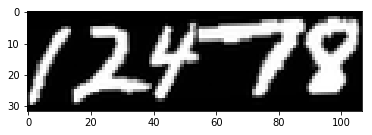

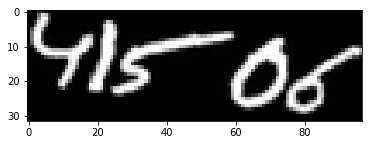

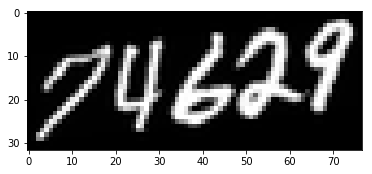

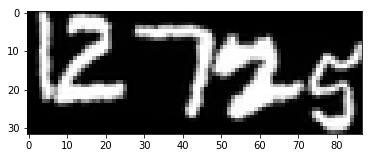

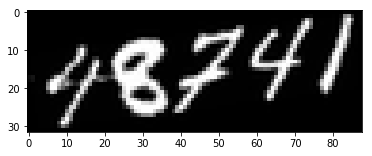

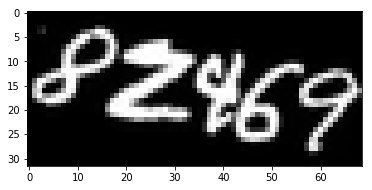

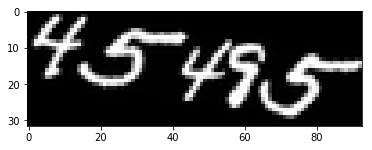

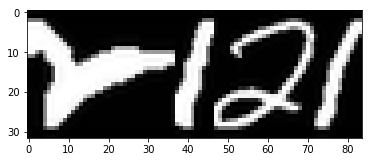

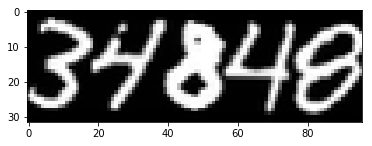

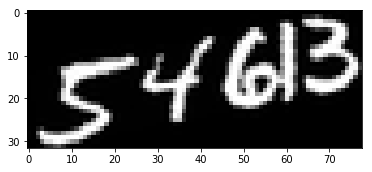

In [21]:
word_images.reset_seed()

for datapoint, _ in word_images:
    show(datapoint)
    plt.show()

In [39]:
word_images.reset_seed()
word_images_by_width_index = sorted(range(len(word_images)), key=lambda i: word_images[i][0].size()[2])

In [40]:
image_directory = '/media/mehdi2277/MyFiles/large_datasets/text_classification/'

In [41]:
word_images.reset_seed()
text_labels_by_width = []

for progress_index, index in enumerate(word_images_by_width_index):
    if progress_index % 1000 == 0:
        print(progress_index)
    
    datapoint, label = word_images[index]
    image = transforms.ToPILImage()(datapoint)
    image_name = str(progress_index) + '.png'
    image_path = os.path.join(image_directory, image_name)
    image.save(image_path)
    text_labels_by_width.append(label)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [42]:
text_labels_by_width = list(map(list, text_labels_by_width))

In [43]:
def index_to_character(index):
    if index < 10:
        return chr(ord('0') + index)
    else:
        return chr(ord('A') + (index - 10))

In [44]:
text_labels_by_width = list(map(lambda word: "".join(map(index_to_character, word)), text_labels_by_width))

In [45]:
text_labels_file_name = 'text_labels_training.json'
text_labels_file_handle = open(image_directory + text_labels_file_name, 'w')
json.dump(text_labels_by_width, text_labels_file_handle)
text_labels_file_handle.close()